# Altamont Grip Type Classifier

The idea here is to use all the website data to identify what type of grip is shown in the photo


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

The data is dumped in from shared/photos to src/data/altamont

In [4]:
PATH = "data\\altamont\\"
sz = 400
#arch = resnext101_64
arch = resnet50
bs = 15
dropout_rate = 0.55

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [6]:
n

669

In [7]:
len(val_idxs)

133

In [8]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
#!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

#!tar xvfz fastai/weights.tgz -C fastai

In [9]:
val_idxs

array([361, 158, 478, 533, 275, 362, 310, 199, 522,  90,  81, 264, 354, 221, 211,  63,  54, 599, 299, 155,
       109, 512, 360, 334, 632, 603, 256, 615, 514,  76, 667, 552, 518, 135, 136, 101,  72, 289,  10, 656,
       577, 319,  31, 554, 396, 464, 623, 118,  55, 257, 593, 346,  77, 569,  78, 638, 575, 336, 352, 181,
       164, 120,   2, 165, 479, 664, 626, 300,  60, 133,  30,  69, 292, 468,  44,  70, 338, 182, 497, 655,
       452, 176, 536,  65, 616,  49, 148, 367,  39, 637, 306,   6, 621, 665, 210, 649, 131, 331, 318, 627,
        86, 462, 281, 559, 622, 636, 470,  41, 192, 108, 602,  56, 311, 494, 284, 132, 220, 250,  24, 208,
       302, 204, 432, 480, 110, 278,  82,  51, 448, 538, 542, 550, 212])

## Initial exploration

In [10]:
import os
os.system("dir " + PATH)


0

In [11]:
label_df = pd.read_csv(label_csv)

In [12]:
label_df.head()

,id,breed
0,BB-UP05-ENG.jpg,B
1,BB-UP07-ENG.jpg,B
2,BB-UP07-OT.jpg,B
3,BC-UP05-CB.jpg,B
4,BC-UP05-OL.jpg,B


We need to have more balanced categories - otherwise it will learn to just say "CG" and be right a good % of the time

In [13]:
#is_cg = label_df[(label_df['breed'] != 'CG') & (label_df['breed'] != 'SJR')]
#len(is_cg)

In [14]:
#label_df = label_df.append(pd.concat([is_cg] * 2, ignore_index=True), ignore_index=True)

In [15]:
#label_df['breed'] = label_df['breed'][0]
#plt.pie(label_df.pivot_table(index="breed", aggfunc=len))

In [75]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

,id
breed,
C,208
S,186
R,125
T,28
B,26
W,24
X,21
K,17
P,17


In [17]:
translation = {"C":"Colt","S":"SW","R":"Ruger","T":"Taurus","B":"Browning","W":"Walther", "X":"Sig","K":"Kimber","P":"Beretta","M":"MSH","Y":"SCREW","L":"LugerLlama","N":"NA","Q":"SW","c":"Colt"}

In [18]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [19]:
tfms

([<fastai.transforms.RandomScale object at 0x000001571BF6F9B0>, <fastai.transforms.RandomRotate object at 0x000001572151D518>, <fastai.transforms.RandomLighting object at 0x000001572151D588>, <fastai.transforms.RandomFlip object at 0x000001572151D5C0>, <fastai.transforms.RandomCrop object at 0x000001571BF6F7F0>, <fastai.transforms.Normalize object at 0x0000015719E8C7B8>, <fastai.transforms.ChannelOrder object at 0x000001571BF6F8D0>],
 [<fastai.transforms.Scale object at 0x0000015719E8C8D0>, <fastai.transforms.CenterCrop object at 0x000001571BC723C8>, <fastai.transforms.Normalize object at 0x0000015719E8C7B8>, <fastai.transforms.ChannelOrder object at 0x000001571BC4E5F8>])

In [20]:
data = ImageClassifierData.from_csv(PATH, 'combined', f'{PATH}labels.csv', test_name='test', 
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)


In [21]:
fn = PATH + data.trn_ds.fnames[154]; fn

'data\\altamont\\combined\\CO-CP01-C01-DD1.jpg'

In [22]:
data.trn_ds.fnames[154:156]

array(['combined\\CO-CP01-C01-DD1.jpg', 'combined\\CO-CP05-3.jpg'], dtype='<U34')

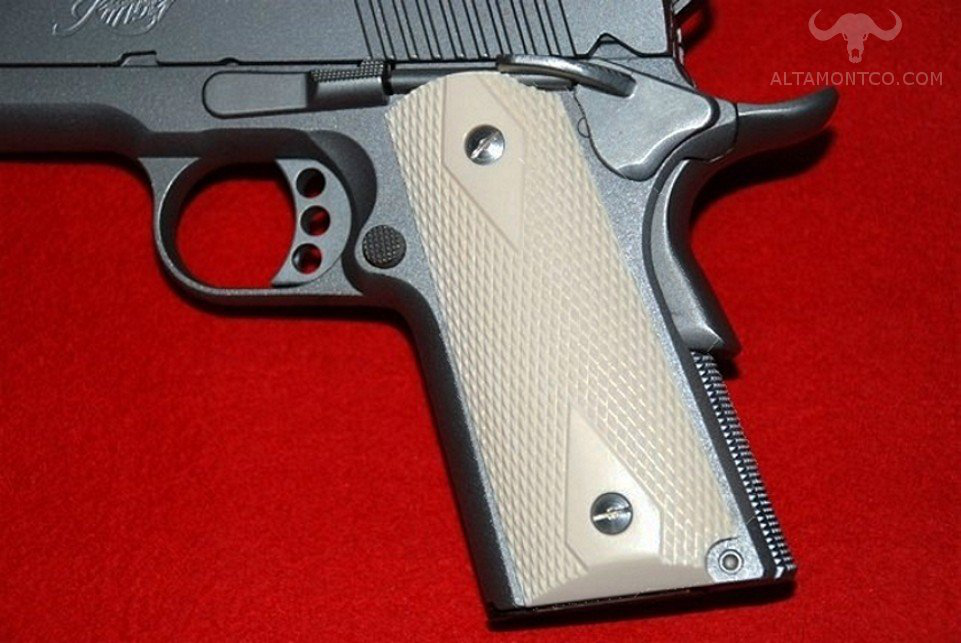

In [23]:
img = PIL.Image.open(fn); img

In [24]:
img.size

(961, 643)

In [25]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [26]:
row_sz, col_sz = list(zip(*size_d.values()))

In [27]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [28]:
row_sz[:5]

array([800, 800, 800, 800, 800])

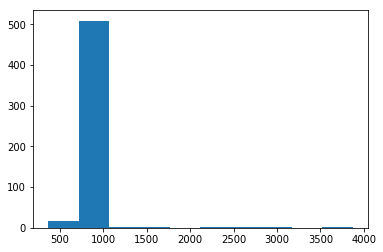

In [29]:
plt.hist(row_sz);

(array([  1.,   3.,   0.,  10.,   1.,   1.,   8., 497.,   0.,   2.]),
 array([367. , 426.4, 485.8, 545.2, 604.6, 664. , 723.4, 782.8, 842.2, 901.6, 961. ]),
 <a list of 10 Patch objects>)

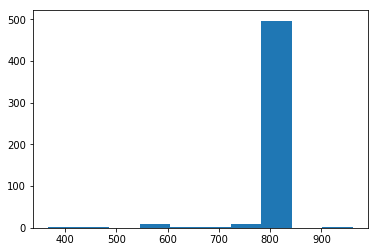

In [30]:
plt.hist(row_sz[row_sz < 1000])

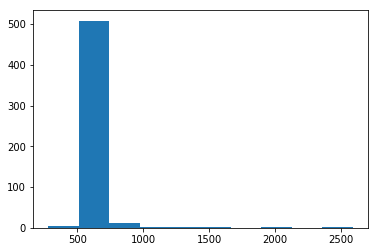

In [31]:
plt.hist(col_sz);

(array([  1.,   0.,   1.,  62., 448.,   1.,   1.,  10.,   0.,   1.]),
 array([278. , 346.2, 414.4, 482.6, 550.8, 619. , 687.2, 755.4, 823.6, 891.8, 960. ]),
 <a list of 10 Patch objects>)

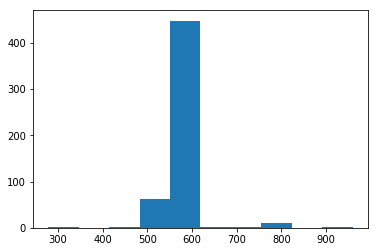

In [32]:
plt.hist(col_sz[col_sz < 1000])

In [33]:
len(data.trn_ds), len(data.test_ds)

(536, 130)

In [34]:
len(data.classes), data.classes[:5]

(15, ['B', 'C', 'K', 'L', 'M'])

## Initial model

In [35]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.5)
    data = ImageClassifierData.from_csv(PATH, 'combined', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    #return data if sz > 350 else data.resize(350, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time
    #return data.resize(600, 'tmp')
    return data
#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Precompute

In [36]:
data = get_data(sz, bs)

In [37]:
tfms

([<fastai.transforms.RandomScale object at 0x000001571BF6F9B0>, <fastai.transforms.RandomRotate object at 0x000001572151D518>, <fastai.transforms.RandomLighting object at 0x000001572151D588>, <fastai.transforms.RandomFlip object at 0x000001572151D5C0>, <fastai.transforms.RandomCrop object at 0x000001571BF6F7F0>, <fastai.transforms.Normalize object at 0x0000015719E8C7B8>, <fastai.transforms.ChannelOrder object at 0x000001571BF6F8D0>],
 [<fastai.transforms.Scale object at 0x0000015719E8C8D0>, <fastai.transforms.CenterCrop object at 0x000001571BC723C8>, <fastai.transforms.Normalize object at 0x0000015719E8C7B8>, <fastai.transforms.ChannelOrder object at 0x000001571BC4E5F8>])

In [38]:
learn = ConvLearner.pretrained(arch, data, precompute=True
                              )

C:\Users\amunchet\Anaconda3\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
C:\Users\amunchet\Anaconda3\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [39]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.725263   0.958393   0.729323  
    1      1.026643   0.891981   0.766917                  
    2      0.620275   0.802356   0.781955                   
    3      0.439522   0.82556    0.759399                   
    4      0.306421   0.760876   0.81203                    



[0.7608757443389946, 0.812030110368155]

### Augment

In [40]:
from sklearn import metrics

In [41]:
data = get_data(sz, bs)

In [42]:
learn = ConvLearner.pretrained(arch, data, precompute=True
                               , ps=dropout_rate)

C:\Users\amunchet\Anaconda3\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
C:\Users\amunchet\Anaconda3\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [43]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.862598   1.069694   0.736842  
    1      1.162705   0.866846   0.75188                  
    2      0.772684   0.861946   0.766917                  
    3      0.57036    0.822819   0.789474                   
    4      0.432456   0.735826   0.81203                   



[0.7358259397341793, 0.8120301200034923]

 92%|█████████▏| 33/36 [00:11<00:00,  6.21it/s, loss=12.2]

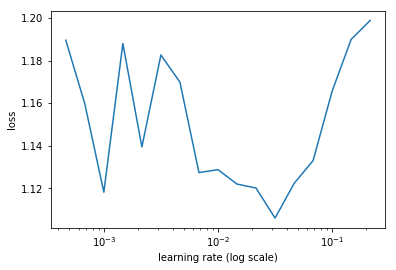

In [44]:
learn.precompute = False
learn.lr_find()
learn.sched.plot()

In [45]:
learn.fit([0.075,.02,0.005], 7, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.064382   0.79634    0.781955  
    1      1.028411   0.800031   0.781955                  
    2      1.025404   0.8231     0.789474                 
    3      0.915314   0.82219    0.781955                  
    4      0.900138   0.809281   0.789474                  
    5      0.855255   0.759141   0.789474                  
    6      0.800013   0.703688   0.81203                   
    7      0.806179   0.725694   0.774436                  
    8      0.76207    0.671147   0.827068                  
    9      0.718047   0.664113   0.834587                  
    10     0.7101     0.680414   0.81203                   
    11     0.721328   0.688929   0.819549                  
    12     0.667214   0.674195   0.81203                   
    13     0.594691   0.665083   0.819549                  


[0.6650834122210517, 0.8195489098254899]

In [46]:
learn.save('altamont_224_pre')

In [47]:
learn.load('altamont_224_pre')

## Individual prediction

In [48]:
fn = data.val_ds.fnames[75]
fn

'combined\\RM4-FG05-BW.jpg'

In [49]:
def run_test_predict(fn):
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
    dl = DataLoader(ds)
    preds = learn.predict_dl(dl)
    return np.argmax(preds)

data.val_ds.y

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  4,  4,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 12,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 11, 11, 11, 11, 11, 11], dtype=int64)

In [50]:
wrong_count = 0
for i in range(0,len(data.val_ds.y)):
    test_pred = run_test_predict(data.val_ds.fnames[i])
    if(test_pred != data.val_ds.y[i]):
        print (i, " - ", data.val_ds.fnames[i],".  Predicted:",translation[learn.data.classes[test_pred]])
        wrong_count += 1


3  -  combined\BH-CS05.JPG .  Predicted: SW
5  -  combined\CC-FO05-STR-NRA1.jpg .  Predicted: Kimber
6  -  combined\CD-FO05-CK.jpg .  Predicted: SW
44  -  combined\CG-UL05-BW.jpg .  Predicted: Beretta
45  -  combined\CG-UL06-CK.jpg .  Predicted: Beretta
52  -  combined\CO-CP13-L01-SSK.jpg .  Predicted: Sig
53  -  combined\CP-CP35.jpg .  Predicted: SW
54  -  combined\CP-FO05-CK-M02L.jpg .  Predicted: Ruger
59  -  combined\PN-FG07-CK.jpg .  Predicted: Colt
60  -  combined\R22-CP05-CK.jpg .  Predicted: Colt
61  -  combined\RB-CP01-CK.jpg .  Predicted: SW
62  -  combined\RG-CC01-SSX2-SO14.jpg .  Predicted: SW
73  -  combined\RM4-CP05-BW.jpg .  Predicted: SW
74  -  combined\RM4-CP05-STP.jpg .  Predicted: SW
75  -  combined\RM4-FG05-BW.jpg .  Predicted: SW
76  -  combined\RM4-FG05-CK.jpg .  Predicted: Kimber
118  -  combined\TI-CP06-USN.jpg .  Predicted: Colt
119  -  combined\TI-CP07-CK.jpg .  Predicted: Colt
120  -  combined\TJ-FO05-CB.jpg .  Predicted: SW
121  -  combined\TJ-FO07-LT.jpg . 

In [95]:
fn = data.val_ds.fnames[120]

In [96]:
wrong_count

24

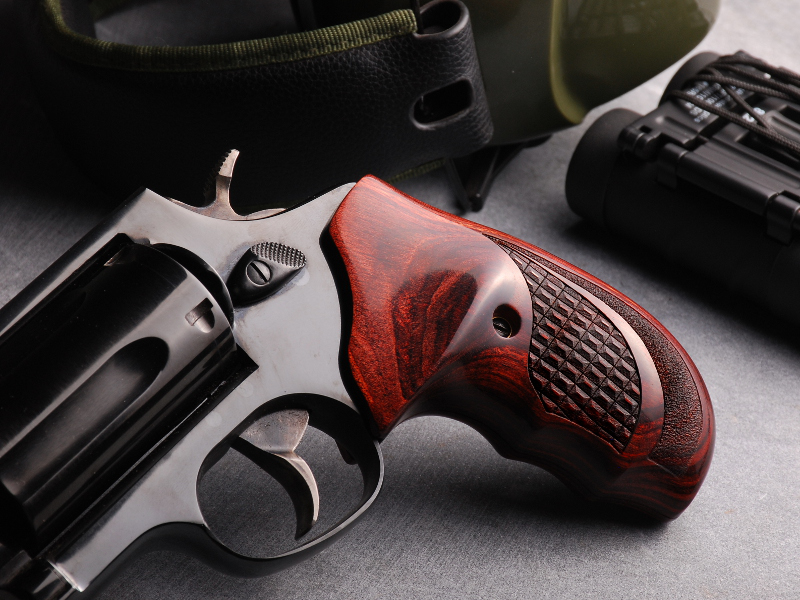

In [97]:
#Image.open(PATH + fn).resize((300, 300))
Image.open(PATH + fn)

In [85]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

9

In [54]:
preds

array([[-5.57786, -1.60032, -0.30063, -7.43221, -6.50764, -6.52809, -9.70787, -6.78976, -3.50736, -4.07438,
        -6.87043, -8.64993, -8.32422, -9.0193 , -7.20154]], dtype=float32)

In [55]:
translation[learn.data.classes[np.argmax(preds)]]


'Kimber'

In [56]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)

2